# Explore implementation of FCN model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds

import src.data.datasets.deep_globe_2018

2024-01-22 21:14:34.321974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reuse code from previous notebooks

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 1

In [3]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [4]:
def rgb_to_index(image):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]
    
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all(tf.equal(image, colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.uint8)
    indexed = tf.math.argmax(one_hot_map, axis=2)
    indexed = tf.cast(indexed, dtype=tf.uint8)
    indexed = tf.expand_dims(indexed, -1)

    return indexed

In [5]:
def load_images(datapoint, image_size):
    
    images = tf.image.resize(datapoint['image'], (image_size, image_size))

    annotations = tf.map_fn(rgb_to_index, datapoint['segmentation_mask'])
    annotations = tf.image.resize(annotations, (image_size, image_size), method='nearest')

    annotations = tf.one_hot(
            annotations,
            depth = 7, # TODO: make depth configurable
            on_value = 1,
            off_value = 0,
            axis = 3
        )
    annotations = tf.squeeze(annotations, axis=4)
    
    images = normalize(images)

    return images, annotations

In [42]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i][0]))
        plt.axis('off')
    plt.show()

In [7]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    name='deep_globe_2018',
    download=False,
    with_info=True,
    split=['all_images[700:710]', 'all_images[7:9]', 'all_images[9:10]']
)
train_batches = (
    ds_train
    .batch(BATCH_SIZE)
    .map(lambda x: load_images(x, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
validation_batches = (
    ds_valid
    .batch(BATCH_SIZE)
    .map(lambda x: load_images(x, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_batches = (
    ds_test
    .batch(BATCH_SIZE)
    .map(lambda x: load_images(x, IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)    

2024-01-22 21:14:41.862792: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Explore model

In [8]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

In [9]:
# Layers that need to be "fully convolutionalized" (layer sizes as per https://doi.org/10.48550/arXiv.1409.1556, last accessed: 22 Jan 2024)
# Conversion as per: https://cs231n.github.io/convolutional-networks/#convert, last accessed: 22 Jan 2024

# FC-4096
block_6_conv1 = tf.keras.layers.Conv2D(
    filters=4096,
    kernel_size=(7,7),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='block_6_conv1'
)

# FC-4096
block_6_conv2 = tf.keras.layers.Conv2D(
    filters=4096,
    kernel_size=(7,7),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='block_6_conv2'
)

# FC-1000 --> This final classifier layer is discarded
# DO NOTHING

# We append a 1 × 1 convolution with channel dimension 21 to predict scores for each of the PASCAL classes at each of the coarse output locations
# Looking at the original implementation there is no explicit activation function: https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/voc-fcn32s/net.py, last accessed 22.01.2024
# Hence "linear" is chosen
block_6_conv3 = tf.keras.layers.Conv2D(
    filters=7,
    kernel_size=(1,1),
    strides=(1,1),
    padding='same',
    activation='linear',
    name='block_6_conv3_score'
)

# followed by a deconvolution layer to bi-linearly upsample the coarse outputs to pixel-dense outputs
block_6_deconv1 = tf.keras.layers.Conv2DTranspose(
    filters=7,
    kernel_size=(64, 64),
    strides=(32, 32),
    use_bias=False, # As per original implementation
    padding='same',
    activation='softmax',
    name='block_6_deconv1'
)
block_6_deconv1.trainable = False # As per original implementation: param=[dict(lr_mult=0)]


In [10]:
# Source: approach to combining VGG16 with additional layers into a single model
# Last accessed: 22.01.2024 https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

x = base_model.output
x = block_6_conv1(x)
x = block_6_conv2(x)
x = block_6_conv3(x) #scoring layer
output_layer = block_6_deconv1(x)

In [11]:
fcn_32s = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

In [12]:
for i, m in train_batches.take(1):
    y = fcn_32s(i)

In [13]:
fcn_32s.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [loss,
           tf.keras.metrics.MeanIoU(num_classes=7)]
fcn_32s.compile(optimizer=opt, loss=loss, metrics=metrics)

In [15]:
fcn_32s.fit(
    train_batches,
    epochs=1
)

10/10 [==============================] - 91s 8s/step - loss: 1.9439 - categorical_crossentropy: 1.9439 - mean_io_u: 0.4286


In [40]:
def one_hot_to_rgb(one_hot_map):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]

    one_hot_map = tf.cast(one_hot_map, tf.int32)
    # Use one-hot map and palette to reconstruct RGB image
    reconstructed_image = tf.reduce_sum(tf.expand_dims(one_hot_map, axis=-1) * tf.constant(palette), axis=-2)

    return tf.cast(reconstructed_image, dtype=tf.uint8)

1/1 [==============================] - 3s 3s/step
3


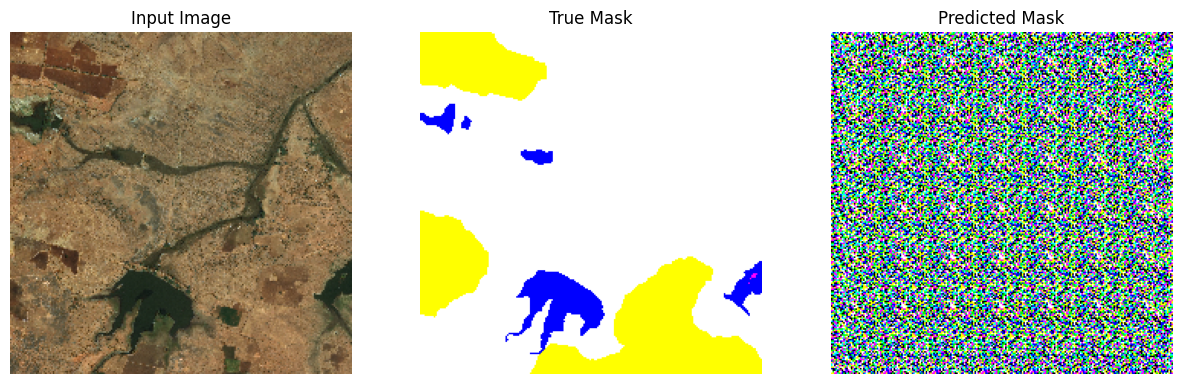

1/1 [==============================] - 3s 3s/step
3


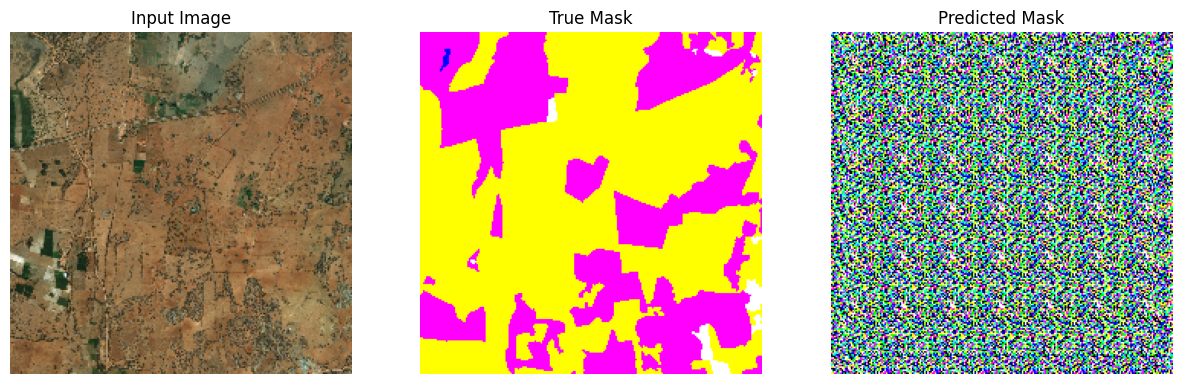

1/1 [==============================] - 3s 3s/step
3


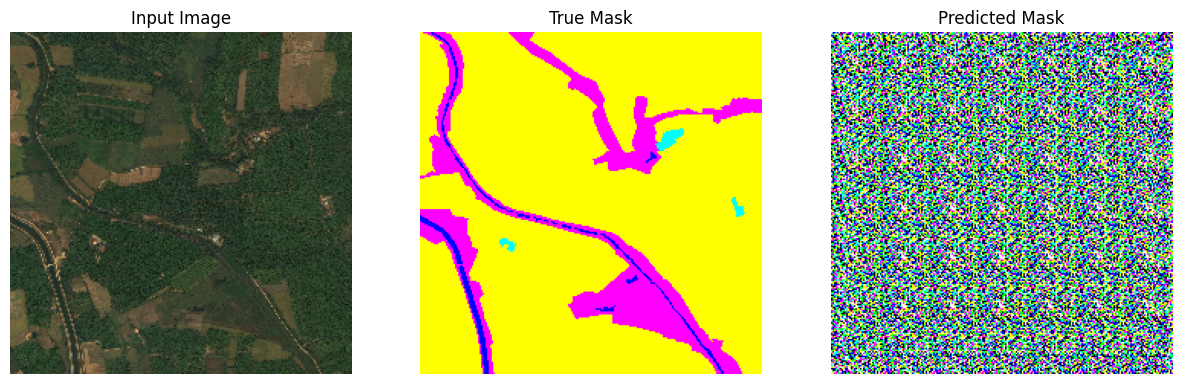

1/1 [==============================] - 3s 3s/step
3


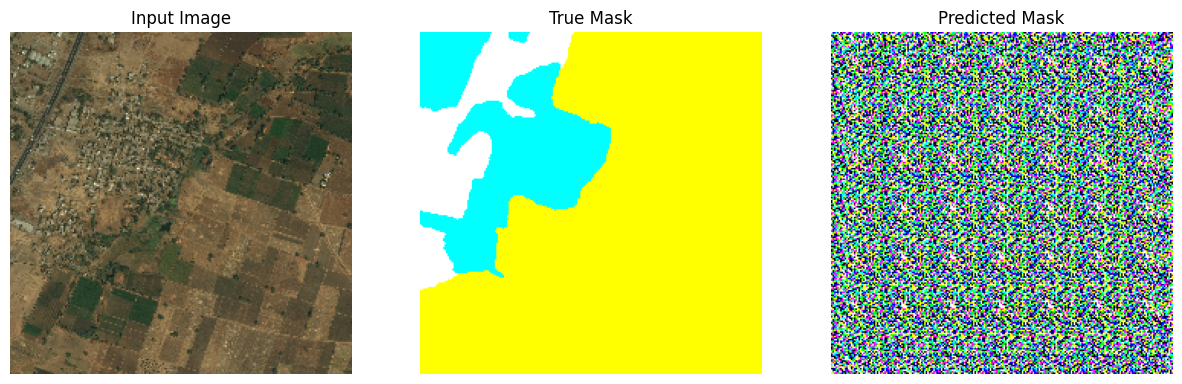

In [43]:
for i, m in train_batches.take(4):
    y = fcn_32s.predict(i)
    y_one_hot = tf.one_hot(tf.argmax(y, axis = 3), depth = 7)
    mask_gt = one_hot_to_rgb(m)
    mask_pred = one_hot_to_rgb(y_one_hot)
    display([i, mask_gt, mask_pred])